In [7]:
# Importing the required libraries

import os
from random import shuffle
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from keras.utils.np_utils import to_categorical

['crop_part1', 'UTKFace']


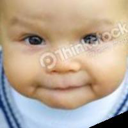

In [8]:
os.chdir('/content/input')
print(os.listdir())

# Checking the directory
os.chdir('UTKFace')

# verifying one of the image as a sample
im = Image.open('1_0_0_20161219140623097.jpg.chip.jpg').resize((128, 128))
im

In [9]:
onlyfiles = os.listdir()
print(len(onlyfiles))

23708


### Separating the labels from the images so that they are stored in the classes and spliting the data into Gender Classes as
### - 0 **Male**
### 1 **Female**

In [10]:
shuffle(onlyfiles)
gender = [i.split('_')[1] for i in onlyfiles]

classes = []
for i in gender:
    i = int(i)
    classes.append(i)

### CONVERT IMAGES TO VECTORS

In [11]:
X_data = []
for file in onlyfiles:
    face = imageio.imread(file)
    face = cv2.resize(face, (128, 128))
    X_data.append(face)

X = np.squeeze(X_data)
print(X.shape)

(23708, 128, 128, 3)


### Normalize data

In [12]:
X = X.astype('float32')
X /= 255

In [13]:
print(classes[:10])
categorical_labels = to_categorical(classes, num_classes=2)
print(categorical_labels[:10])

[1, 1, 0, 0, 0, 1, 1, 1, 1, 0]
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


### Splitting the data

In [14]:
(x_train, y_train), (x_test, y_test) = (X[:15008], categorical_labels[:15008]), (X[15008:], categorical_labels[15008:])
(x_valid, y_valid) = (x_test[:7000], y_test[:7000])
(x_test, y_test) = (x_test[7000:], y_test[7000:])
len(x_train) + len(x_test) + len(x_valid) == len(X)

True

### Model Creation

In [15]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(128, 128, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0

### Compiling the Model

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Model fit

In [17]:
model.fit(x_train,
          y_train,
          batch_size=64,
          epochs=10,
          validation_data=(x_valid, y_valid), )

Epoch 1/10
235/235 [==============================] - 23s 99ms/step - loss: 0.6512 - accuracy: 0.6788 - val_loss: 0.4727 - val_accuracy: 0.7973
Epoch 2/10
235/235 [==============================] - 23s 97ms/step - loss: 0.4252 - accuracy: 0.8031 - val_loss: 0.3598 - val_accuracy: 0.8453
Epoch 3/10
235/235 [==============================] - 23s 97ms/step - loss: 0.3769 - accuracy: 0.8295 - val_loss: 0.3309 - val_accuracy: 0.8500
Epoch 4/10
235/235 [==============================] - 23s 97ms/step - loss: 0.3471 - accuracy: 0.8440 - val_loss: 0.3222 - val_accuracy: 0.8576
Epoch 5/10
235/235 [==============================] - 23s 97ms/step - loss: 0.3357 - accuracy: 0.8485 - val_loss: 0.3049 - val_accuracy: 0.8684
Epoch 6/10
235/235 [==============================] - 23s 97ms/step - loss: 0.3237 - accuracy: 0.8543 - val_loss: 0.2980 - val_accuracy: 0.8670
Epoch 7/10
235/235 [==============================] - 23s 97ms/step - loss: 0.3106 - accuracy: 0.8609 - val_loss: 0.2925 - val_accuracy:

### Saving the Model

In [19]:
model.save('/content/model2.h5')

### Evaluate the model on test set and its Accuracy

In [20]:
score = model.evaluate(x_test, y_test, verbose=0)

print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.8788235187530518


In [21]:
labels = ["Male",  # index 0
          "Female",  # index 1
          ]
print('Male ->', '0', '\nFemale ->', '1')

Male -> 0 
Female -> 1


In [22]:
y_hat = model.predict(x_test)

### Plotting a random sample of 10 test images, their predicted labels and ground truth

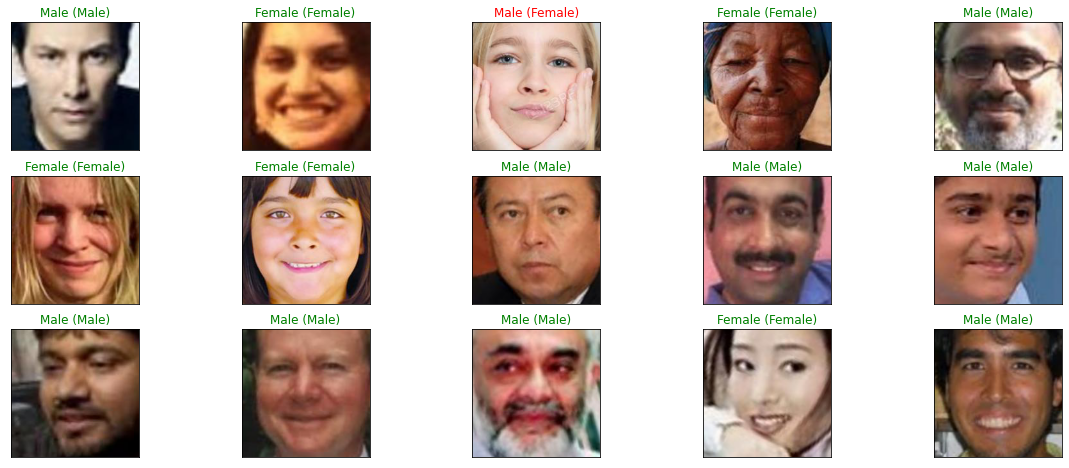

In [23]:
# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index],
                                  labels[true_index]),
                 color=("green" if predict_index == true_index else "red"))
plt.show()

# Question and Answers

#### Question: Do you get the same results if you run the Notebook multiple times without changing any parameters?
""" NO, the result varies"""

#### Question: What is the effect of adding more neurons to each Conv2D layer?
""" The model gets more adaptive, so it can learn smaller details. But this means not necessary, that the classifier is then better on the 'next dataset'. 
The model gets more affected to over-fitting and so the generalization of your classification model can also decrease, 
e.g. this classifier will work worse on the next dataset."""

#### Question: What happens if we manipulate the value of dropout?
""" With dropout (dropout rate less than some small value), the accuracy will gradually increase, and loss will gradually decrease first. 
When you increase dropout beyond a certain threshold, it results in the model not being able to fit properly. 
Intuitively, a higher dropout rate would result in a higher variance to some of the layers, which also degrades training."""


#### Question: What is the effect of adding more hidden layers to the network?
""" Adding layers increases the number of weights in the network, therefore the model complexity. 
Without a large training set, an increasingly large network is likely to overfit and in turn reduce accuracy on the test data."""


#### Question: What is the purpose of MaxPooling2D layer?
""" To down-sample an input representation (image, hidden-layer output matrix, etc.), reducing its dimensionality and allowing for assumptions to be made about features contained in the sub-regions"""

#### Question: Does manipulating the learning rate affect the model? Justify your answer.
"""The learning rate is a configurable hyperparameter used in the training of neural networks 
that has a small positive value, ranges between 0.0 and 1.0. When the learning rate is too large, 
gradient descent can unintentionally increase rather than decrease the training error. When the learning rate is too small, training is not only slower, but may become permanently stuck with a high training error."""


#### Question: Write up a summary explaining how your program works 
""" 
Here is the summary of the program:

*   First and foremost: Importing the libraries
*   Checking the input data directory
*   verifying one of the image as a sample
*   Preparing the Data
*   Preprocessing on the data
*   Split my model into training, validation and test sets
*   Creation of a model
*   model summary
*   Building and Compile the model.
*   Train the model
*   Saving the Model
*   Model elavuation and its accuracy
*   Finally plotting a random sample of 10 test images, their predicted labels and ground truth


"""